In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader,PyMuPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_core.runnables import RunnableParallel,RunnablePassthrough,RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain.retrievers import EnsembleRetriever,ContextualCompressionRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_cohere import CohereRerank
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import os
load_dotenv()

True

### Document Loading

In [4]:
def doc_load(path):
    return DirectoryLoader(path,glob="*.pdf",loader_cls=PyMuPDFLoader).load()


path_to_dentist = "data/Dentist"
path_to_biology = "data/Dermatology"
path_to_psychiartrist = "data/psychiatrist"

dentist_document = doc_load(path_to_dentist)
dermatology_document = doc_load(path_to_biology)
psychiatrist_document = doc_load(path_to_psychiartrist)

print("len of dermatology ",len(dermatology_document))
print("len of dentist ",len(dentist_document))
print("len of psychiatrist ",len(psychiatrist_document))

len of dermatology  959
len of dentist  1449
len of psychiatrist  1564


### Text Chunking

In [5]:
def text_splitter(doc):
    return RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=400).split_documents(doc)

dermatology_chunks = text_splitter(dermatology_document)
dentist_chunks = text_splitter(dentist_document)
psychiatrist_chunks = text_splitter(psychiatrist_document)

print("len of dentist chunnks:",len(dentist_chunks))
print("len of dermatology chunnks:",len(dermatology_chunks))
print("len of psychiatrist chunnks:",len(psychiatrist_chunks))

len of dentist chunnks: 4484
len of dermatology chunnks: 2030
len of psychiatrist chunnks: 3761


### Creating Vector Store

In [6]:
from langchain.vectorstores import FAISS
import os
from tqdm import tqdm

embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

batch_size=40
def create_vector_store(chunks,path):
    vectore_store =None
    for i in tqdm(range(0,len(chunks),batch_size)):
        batch = chunks[i:i+batch_size]
        if vectore_store is None:
            vectore_store = FAISS.from_documents(embedding=embedding_model,documents=batch)
        else:
            new_store = FAISS.from_documents(embedding=embedding_model,documents=batch)
            vectore_store.merge_from(new_store)
    vectore_store.save_local(folder_path=path)
    return vectore_store

os.makedirs("FAISS/dermatology", exist_ok=True)
os.makedirs("FAISS/dentis", exist_ok=True)
os.makedirs("FAISS/psychiatrist", exist_ok=True)

dermatology_vector_store_path = "FAISS/dermatology/"
dentis_vector_store_path =  "FAISS/dentis/"
psychiatrist_store_path = "FAISS/psychiatrist"

dermatology_vector_store = create_vector_store(dermatology_chunks,dermatology_vector_store_path) 
dentis_vector_store = create_vector_store(dentist_chunks,dentis_vector_store_path)
psychiatrist_store = create_vector_store(psychiatrist_chunks,psychiatrist_store_path)

print("Vector store created successfult")

100%|██████████| 95/95 [02:36<00:00,  1.64s/it]

Vector store created successfult


## Loading Vector Stores

In [6]:
from langchain.vectorstores import FAISS
dermatology_vector_store_path = "FAISS/dermatology/"
dentis_vector_store_path =  "FAISS/dentis/"
psychiatrist_store_path = "FAISS/psychiatrist"

embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",batch_size=20)

dermatology_vector_store = FAISS.load_local(folder_path=dermatology_vector_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)
dentis_vector_store = FAISS.load_local(folder_path=dentis_vector_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)
psychiatrist_vector_store = FAISS.load_local(folder_path=psychiatrist_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)

### Retriever(Dense)

In [8]:
dermatology_retriever = dermatology_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":3})
dentist_retriever = dentis_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":3})
psychiatrist_retriever = psychiatrist_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":3})

dermatology_retriever.invoke("What are som skin disease")

[Document(id='0824686e-1081-409c-8e6f-dbd95c9d51ea', metadata={'producer': 'Adobe Acrobat Pro 11.0.0 Paper Capture Plug-in', 'creator': 'Adobe InDesign CC 2015 (Windows)', 'creationdate': '2017-02-19T22:14:14+00:00', 'source': 'data\\Dermatology\\Oxford-Handbook-of-Medical-Dermatology.pdf', 'file_path': 'data\\Dermatology\\Oxford-Handbook-of-Medical-Dermatology.pdf', 'total_pages': 717, 'format': 'PDF 1.6', 'title': 'Oxford Handbook of Medical Dermatology', 'author': 'Susan Burge,Rubeta Matin,Dinny Wallis', 'subject': '', 'keywords': '', 'moddate': '2017-04-23T17:17:47+02:00', 'trapped': '', 'modDate': "D:20170423171747+02'00'", 'creationDate': 'D:20170219221414Z', 'page': 710}, page_content='keratoacanthoma\u2002 350\nleukaemia cutis\u2002 361\nmelanoma\u2002 see malignant \nmelanoma\nMerkel cell carcinoma\u2002 360\nmetastatic\u2002 360\nPaget disease\u2002 360\npremalignant epidermal \nlesions\u2002 348\nprevalence\u2002 55\nrenal transplant \nrecipients\u2002 500\nrisk factors\u200

## Retriever(Sparse)

In [9]:
bm25_retriever_dentist = BM25Retriever.from_documents(dentist_chunks)
bm25_retriever_dentist.k=2

bm25_retriever_dermatology = BM25Retriever.from_documents(dermatology_chunks)
bm25_retriever_dermatology.k=2

bm25_retriever_psychiatrist = BM25Retriever.from_documents(psychiatrist_chunks)
bm25_retriever_psychiatrist.k=2

### Dense Retriever

In [10]:
hybrid_retrieval_dermatology = EnsembleRetriever(
    retrievers=[dermatology_retriever,bm25_retriever_dermatology],
    weights=[0.4,0.6]
)

hybrid_retrieval_dentist = EnsembleRetriever(
    retrievers=[dentist_retriever,bm25_retriever_dentist],
    weights=[0.4,0.6]
)

hybrid_retrieval_psychiatrist = EnsembleRetriever(
    retrievers=[psychiatrist_retriever,bm25_retriever_psychiatrist],
    weights=[0.5,0.5]
)

In [11]:
from langchain.document_transformers import LongContextReorder,EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
filter = EmbeddingsRedundantFilter(embeddings=embedding_model)
context_reorder = LongContextReorder()  #it may score document chunks based on some heuristic (like token overlap, density, metadata relevance), and then reorder them accordingly.
reranker = CohereRerank(model = "rerank-english-v3.0")

pipe = DocumentCompressorPipeline(transformers=[filter,context_reorder,reranker])

In [12]:
final_retriever = ContextualCompressionRetriever(
    base_retriever=hybrid_retrieval_dermatology,
    base_compressor=pipe
)

In [13]:
parser = StrOutputParser()
prompt_text = PromptTemplate(
    template="""You are a highly accurate medical assistant.
        Use only the given context to answer the user's question.
        If the context does not contain the information needed, simply reply:
        "I don't know based on the given context."
        CONTEXT:
        {context}
        QUESTION:
        {question}
        Your Answer:""",
input_variables=["context", "question"])

In [14]:
callback = [StreamingStdOutCallbackHandler()]
model = ChatGroq(model="deepseek-r1-distill-llama-70b",streaming=True,callbacks=callback)

In [ ]:
for chunk in model.stream("tell me about Pakistan in 7 lines"):
    print(chunk.content, end="")

## Text Generation Chain

In [15]:
import re

def context_format(context):
    return "\n\n".join(getattr(doc,"page_content") for doc in context)

def remove_think_tags(text):
    return re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()

parallel_chain = RunnableParallel({
      "context": final_retriever | RunnableLambda(context_format),
      "question":RunnablePassthrough()
  })

text_chain = parallel_chain | prompt_text | model | parser | RunnableLambda(remove_think_tags)

In [16]:
from IPython.display import display,Markdown
result = text_chain.invoke("What are some common skin disease")
display(Markdown(result))


<think>
Okay, so I need to figure out the answer to the question, "What are some common skin diseases?" using the provided context. Let me start by going through the context carefully to identify all the relevant information.

Looking at the context, I see several sections that list different skin conditions. The first part mentions excluding infections or trauma when seeing blisters and considering photosensitizing drugs before diagnosing LE. Then, there's a section titled "What is common?" which breaks down skin diseases into categories: infections, infestations, inflammatory diseases, tumors, hair loss, ulcers, and pigment changes.

Under infections, it lists bacterial (cellulitis, impetigo), viral (herpes simplex, varicella-zoster, warts, molluscum), and fungal (dermatophyte, yeast). Infestations include scabies, fleas, and lice. Inflammatory diseases include acne, eczema, psoriasis, and urticaria. Tumors are categorized into benign, premalignant (like solar keratoses, Bowen diseas

**Common Skin Diseases**

1. **Infections:**
   - **Bacterial:** Cellulitis, Impetigo
   - **Viral:** Herpes simplex, Varicella-zoster, Warts, Molluscum
   - **Fungal:** Dermatophytes, Yeast

2. **Infestations:**
   - Scabies, Fleas, Lice

3. **Inflammatory Diseases:**
   - Acne, Eczema, Psoriasis, Urticaria

4. **Tumors:**
   - **Benign**
   - **Premalignant:** Solar keratoses, Bowen disease
   - **Malignant:** Basal Cell Carcinoma (BCC), Squamous Cell Carcinoma (SCC), Malignant Melanoma

5. **Other Conditions:**
   - Hair loss or gain
   - Chronic leg ulcers
   - Pigment changes (gain or loss)

These categories cover a wide range of common skin diseases encountered in both community and hospital settings.

# Vision Model

In [ ]:
# model_image = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
vision_model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

### Loading Image From Link

In [ ]:
import requests
import os
from PIL import Image   # pillow

def get_image(url,file_name,extension):
    os.makedirs("content",exist_ok=True)
    content = requests.get(url).content

    #save image to gile
    file_path = f"content/{file_name}.{extension}"
    with open(file_path,"wb") as f:
        f.write(content)

    image = Image.open(file_path)
    image.show()
    return image

image_url = "https://earthshotprize.org/wp-content/uploads/2023/05/bee-on-flower.jpg"
pil_image = get_image(image_url,"cat","png")

### Converting Image to text to feed in to Model

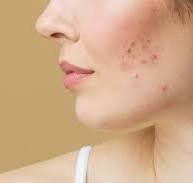

In [ ]:
# Base64 is a way of encoding binary data (like images, files, or videos) into a text format using only ASCII characters (letters, numbers, and a few symbols)
# Base64 converts an image (or any file) into text.

import base64
from io import BytesIO
from PIL import Image

# model except image in base64 format
def extract_text_from_image(pil_image,format="png"):
    buffered = BytesIO()
    buffered.seek(0) ## Reset the buffer's position to the beginning
    pil_image.save(buffered,format=format)
    img_base64 = base64.b64encode(buffered.read()).decode()
    return f"data:image/{format.lower()};base64,{img_base64}"  # data : It tells the browser or application that the content which follows is not a normal URL, but actual data

pil = Image.open("image/acne.jpg")
image = extract_text_from_image(pil)

pil

In [35]:
def create_vision_message(pil_image,query):
    message = HumanMessage(content=[{
        "type":"text",
        "text":query},
        {
            "type":"image_url",
            "image_url":{"url":pil_image}
        }
        ])
    return message
    
message = create_vision_message(image,"explain this image")

vision_result = vision_model.invoke([message]).content

display(Markdown(vision_result))

The image depicts a close-up of the right side of a person's face, showcasing their nose, mouth, and cheek. The individual has fair skin and short brown hair.

**Key Features:**

* **Skin Condition:** The person's cheek exhibits several red acne spots, varying in size and intensity.
* **Attire:** A white strap is visible on their shoulder, suggesting they may be wearing a tank top or similar garment.
* **Background:** The background of the image is a solid tan color.

**Overall Impression:**

The image appears to be a stock photo or illustration related to acne or skin care, given the focus on the person's facial skin condition.

In [ ]:
vision_model = ChatGoogleGenerativeAI(model = "models/gemini-1.5-flash")

def create_vision_message(pil_image,query):
    message = HumanMessage(content=[{
        "type":"text",
        "text":query},
        {
            "type":"image_url",
            "image_url":{"url":pil_image}}])
    return message
message = create_vision_message(image,"is the person happy in the image")


def context_format(context):
    return "\n\n".join(getattr(doc,"page_content") for doc in context)

parallel_chain = RunnableParallel({
      "context": final_retriever | RunnableLambda(context_format),
      "question":RunnablePassthrough(),
  })

vision_chain =  RunnablePassthrough() | vision_model | parser | parallel_chain

output = vision_chain.invoke([message])
output

{'context': 'Assessing the\xa0impact of\xa0skin conditions\n35\n\nskin (photoageing) or skin cancer (see E p. 43)? Are these signs appro-\npriate for the age and lifestyle of the patient or greater than you would \nexpect?\nIs there sparing of covered skin, with a sharp cut-\u200boff between \ninvolved and uninvolved skin?\xa0Check:\n•\t Around the orbit (ask the patient to close his/\u200bher eyes to see the \neyelids).\n•\t Under the frame of spectacles.\n•\t The upper\xa0lip.\n•\t Under the\xa0nose.\n•\t Deep wrinkles on the\xa0face.\n•\t Below the\xa0chin.\n•\t Behind the\xa0ears.\n•\t Under the hair—\u200bon the forehead or at the back of the neck. Is a \nspared area exposed, because the hair has been cut recently?\n•\t Under watch straps.\n•\t The distal phalanges, because the hands often sit with fingers \ncurled.\n•\t Between the fingers.\n•\t Under the\xa0shoe.\n\n•\t Look for signs of chronic sun damage, e.g. mottled pigmentation, \ntelangiectasia, yellowing, wrinkling, and k

## Record Audio

In [24]:
import speech_recognition as sr
from pydub import AudioSegment
from io import BytesIO
import logging

In [30]:
logging.basicConfig(level=logging.INFO,format="%(asctime)s - %(levelname)s - %(message)s")

# %(asctime)s: Timestamp of the log entry
# %(levelname)s: Log level (INFO, WARNING, ERROR, etc.)
# %(message)s: The actual log message

In [39]:

def record_audio(save_path):
    recognizer = sr.Recognizer()
    try:
        with sr.Microphone() as source:
            logging.info("adjusting ambient noise....")
            recognizer.adjust_for_ambient_noise(source,duration=1)
            logging.info("Start speaking now....")

            audio = recognizer.listen(source=source,timeout=15)
            logging.info("Recording completed")

            wav_data = audio.get_wav_data()
            audio_segment = AudioSegment.from_file(BytesIO(wav_data),format="wav")

            audio_segment.export(save_path,format="mp3",bitrate="128k")
            logging.info(f"Audio File saved to {save_path}")
    except Exception as e:
        logging.error(f"Error : {e}")


os.makedirs("Audio/Input_audio",exist_ok=True)
save_path =  "Audio/Input_audio/user_input.mp3"
record_audio(save_path=save_path)

2025-05-26 19:38:34,537 - INFO - adjusting ambient noise....
2025-05-26 19:38:35,537 - INFO - Start speaking now....
2025-05-26 19:38:41,210 - INFO - Recording completed
2025-05-26 19:38:43,003 - INFO - Audio File saved to Audio/Input_audio/user_input.mp3


## Voice to Text

In [45]:
from groq import Groq
model_stt = "whisper-large-v3-turbo"

In [47]:
client = Groq()
model_stt = "whisper-large-v3-turbo"
audio_file = open(save_path,"rb")

transcription = client.audio.transcriptions.create(
    model = model_stt,
    file = audio_file,
    language = "en"
)

print(transcription.text)


2025-05-26 19:47:50,174 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"


 My name is Hasib.
